# Welcome to the DBUxHalfspace hackathon
## Table of contents

- [First steps](#step0)
- [File structure](#struktur)
- [Event](#event)
- [Tracking](#tracking)
- [Event -> tracking](#event_to_tracking)

---

<a id="step0"></a>

# Downloading the data 
1. Access data and videos from this [dropbox folder](https://www.dropbox.com/scl/fo/g7bh4jqsnjtm28cp9c95p/ALzCzF4QhyH0Vrku6e5wTMA?rlkey=gin3hoka00ccjpnzbnzcgzxbl&st=9w01r724&dl=0) and use the password that was provided in the thursday morning presentation. 
    
    Start by downloading the `data/events.csv`, and `data/U21_EURO2025/UKR-DEN_U21EUROS25`, and then download the rest of the competition folders as needed in the background.
    
    Note: you might need to download each competition folder separately due to size limits on dropbox.

2. Move the downloaded files into the /data folder within this directory. The relative paths should match the ones in dropbox. 

3. In the end you should have the following folders 📁 and the following .csv files 📄 inside /data:
- 📁 H_EURO2024/
- 📁 Q_EURO2025/
- 📁 U21_EURO2025/
- 📁 videos/
- 📄 events.csv
- 📄 subs.csv


The competition folders consists of tracking data for each player from the home and away team. 

Events.csv and subs.csv contains event data and substitution data for all games.

Videos folder contains video footages of the match that can be helpful to validate your analysis.

**Be aware that especially the event data can be imperfect, since it is manually tagged.**      


## Event data
Event data describes the ball's movements during the match. 
The event data for this hackathon is produced by Wyscout, and their event data "lives" in the following coordinate system:

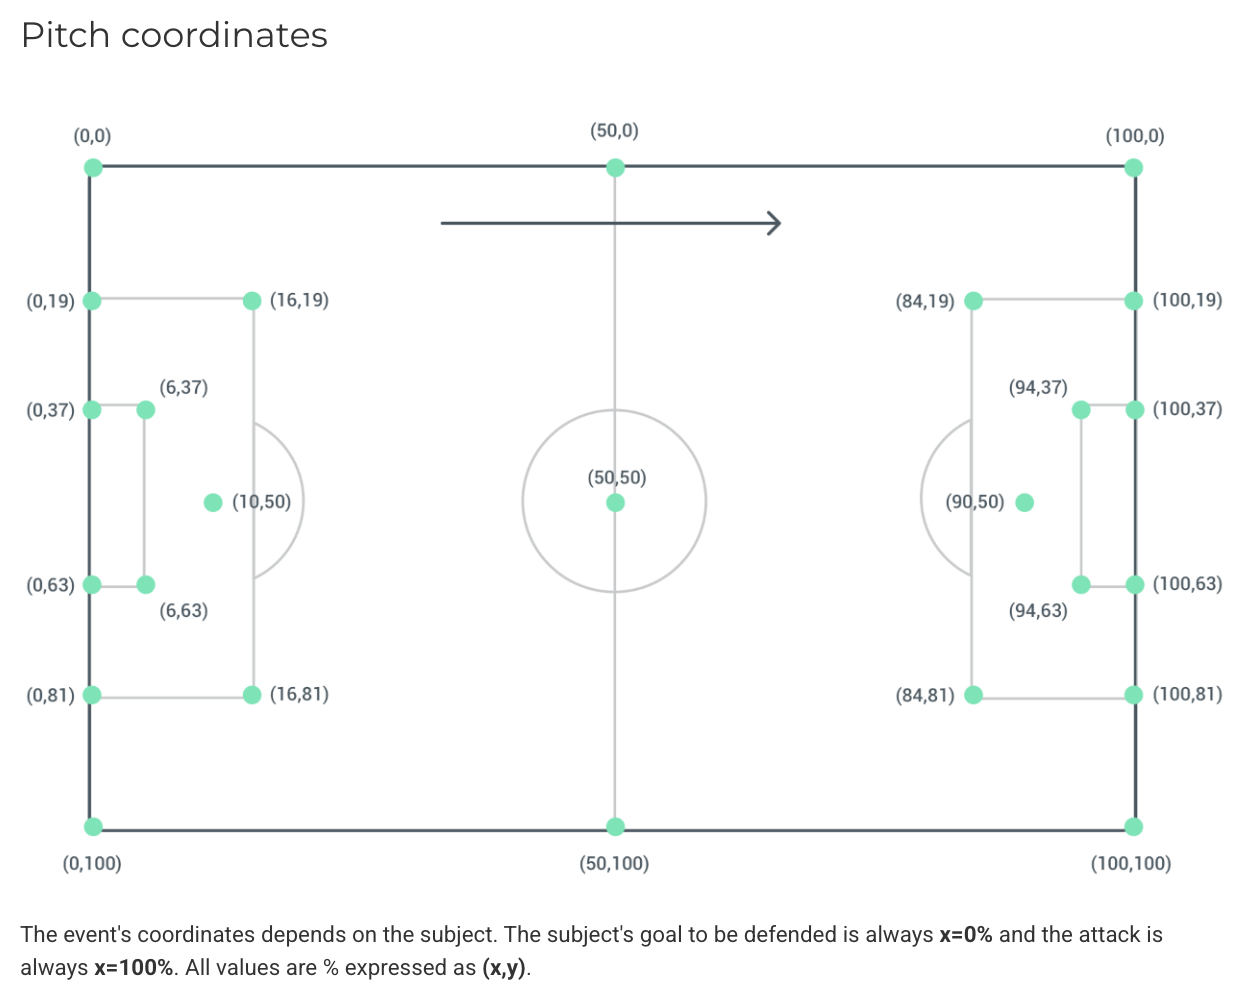

In [1]:
from IPython.display import Image
from src.configs.directories import Directories
Image(filename='pngs/wyscout_pitch_coordinates.png')

You read the event data like this:

In [2]:
from src.data_loader import DataLoader
data_loader = DataLoader()  
events = data_loader.events_df

You can also get all events from a specific competitions or all matches for a specific team. 
Be aware that the womens/mens national teams are named the same in the event data.

In [3]:
events_denmark_u21 = data_loader.load_event_matches(competition="U21_EURO2025", team="Denmark")

And you can now explore the events -- for instance the types of events and how often they occur:


In [4]:
events.typePrimary.value_counts()

typePrimary
pass                       98460
duel                       42014
touch                      15257
interception                8326
game_interruption           7490
throw_in                    4290
free_kick                   2878
shot                        2669
infraction                  2659
goal_kick                   1831
clearance                   1286
corner                      1133
shot_against                1026
acceleration                 749
goalkeeper_exit              355
offside                      341
fairplay                      70
postmatch_penalty             61
postmatch_penalty_faced       55
penalty                       36
own_goal                      15
Name: count, dtype: int64

You can read about the different types of events (definitions, examples, etc.) here: [Wyscout Event Types](https://dataglossary.wyscout.com)

You can show the shots from a single game like this:

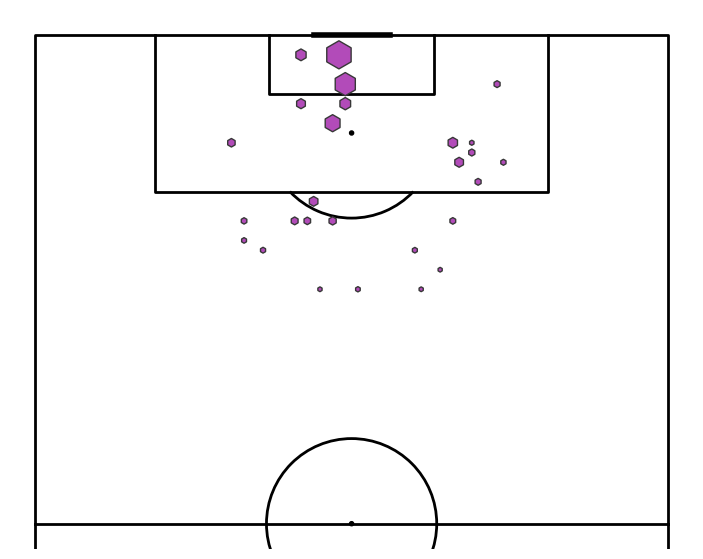

In [5]:
#plenty of great plotting functionality here: https://mplsoccer.readthedocs.io/en/latest/gallery/index.html
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

pitch = VerticalPitch(pitch_type='wyscout', pitch_color='None', line_color='Black',half=True)
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

#filter out Denmark U21 shots against Ukraine U21
den_u21_against_ukraine_shots = events_denmark_u21.query("label == 'Ukraine U21 - Denmark U21, 2 - 3' and typePrimary == 'shot'") 

#scatter the shots on the pitch, scale size by xG
sc = pitch.scatter(den_u21_against_ukraine_shots.x, den_u21_against_ukraine_shots.y,
                   s=(den_u21_against_ukraine_shots.xG * 500),
                   c="#b24bb9",  # color for scatter in hex format
                   edgecolors='#383838',  # give the markers a charcoal border
                   marker='h',# for other markers types see: https://matplotlib.org/api/markers_api.html
                   ax=ax)

<a id="tracking"></a>

## Tracking data

The tracking data has been produced by three different providers (one per tournament). Since every provider uses their own coordinate system, we always transform the data into a "DBU tracking data format" that looks like this:

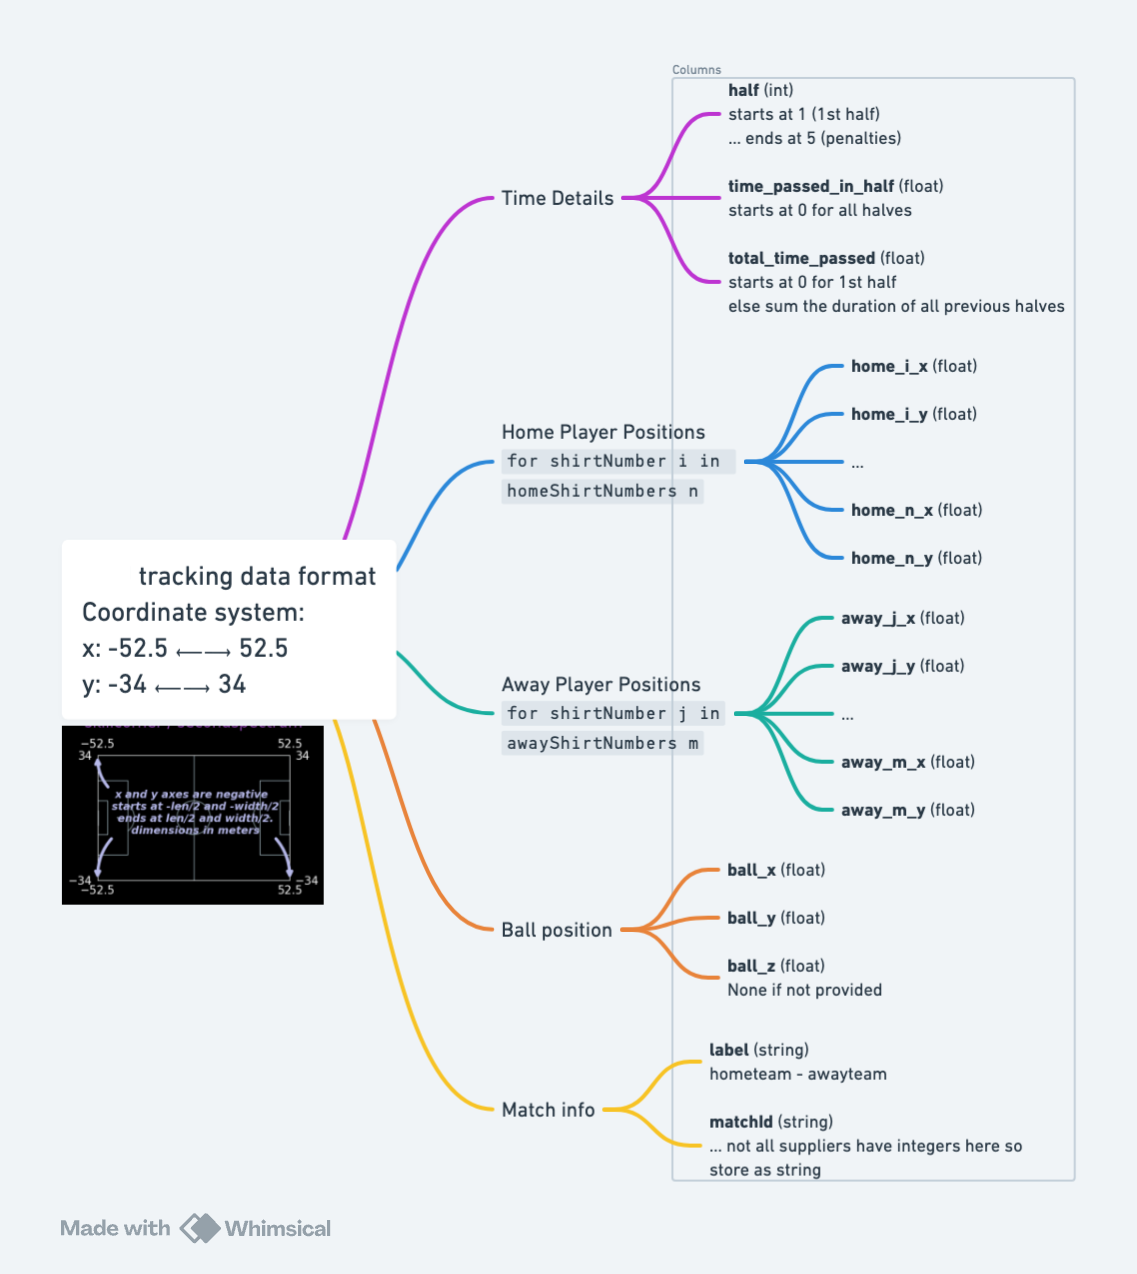

In [6]:
from IPython.display import Image
from src.configs.directories import Directories
Image(filename=Directories.REPO_PATH / 'pngs/tracking_data_structure.png')

Notice that the home team always attacks left to right, and that the center of the pitch is at (0,0) -- both these things are different from wyscout's coordinate system.

You can read in the tracking data and plot it like this:

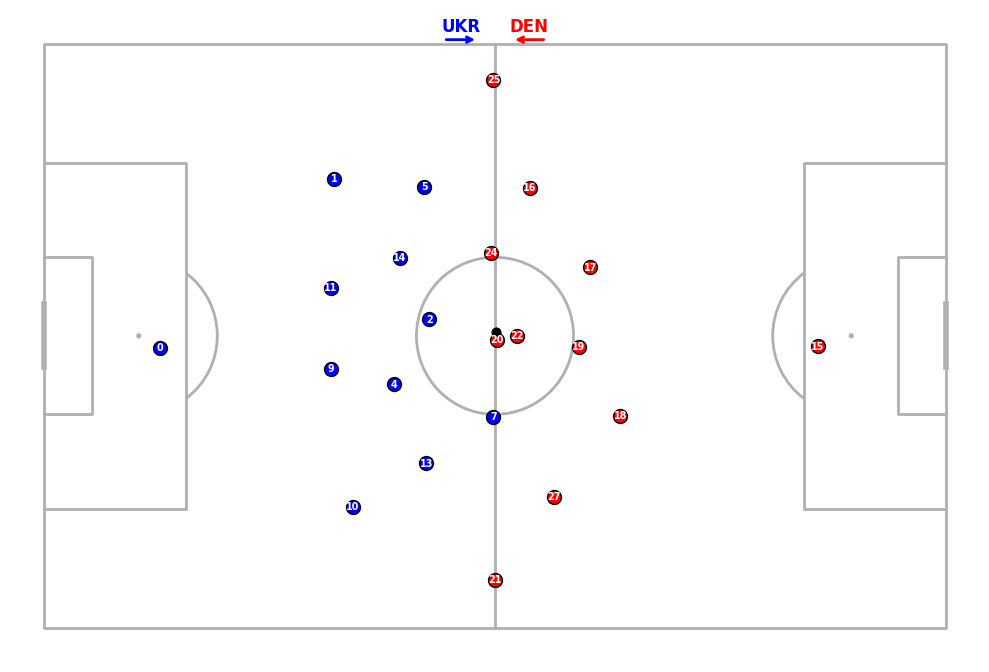

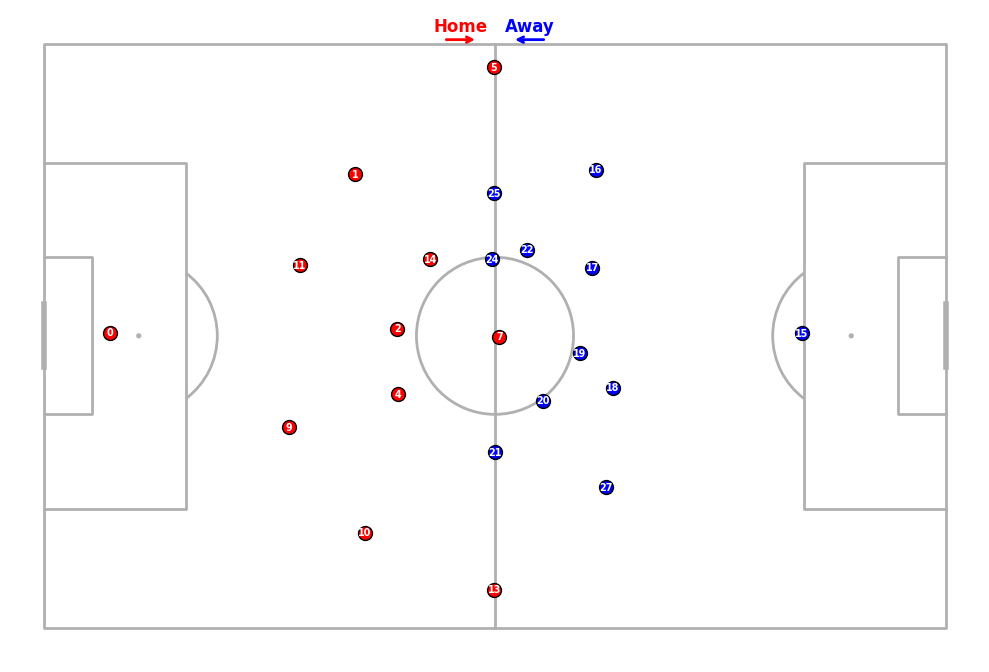

In [7]:
import pandas as pd 
import utils as ut

#read in the Ukraine U21 vs Denmark U21 tracking data
match_id = den_u21_against_ukraine_shots.matchId.unique().item()
home, away = data_loader.load_tracking_data(match_id=match_id, home_or_away='both')

#plot first frame in first half
ut.plot_tracking(home=home, away=away, half=1, time=0, home_color='blue', away_color='red',home_label='UKR',away_label='DEN')

#plot first frame in second half with default colors (home is red and away is blue) and default team labels
ut.plot_tracking(home, away, 2, 0)


<a id="event_to_tracking"></a>

# Combining event with tracking data
The way to combine event and tracking data is simple:

Find the half and timestamp from the event row and plot the closest tracking frame (the plotting function already has this functionality, so all we have to do is extract half and timestamp from the event).

There's a function in utils (ut) extract_half_and_time_passed_in_half(event) that does this.

So, if we want to find the tracking data for the first Danish shot in the U21's game against Ukraine:

In [8]:
half, time_passed_in_half = ut.extract_half_and_time_passed_in_half(event=den_u21_against_ukraine_shots.iloc[0])

And we can plot the corresponding tracking frame like this:

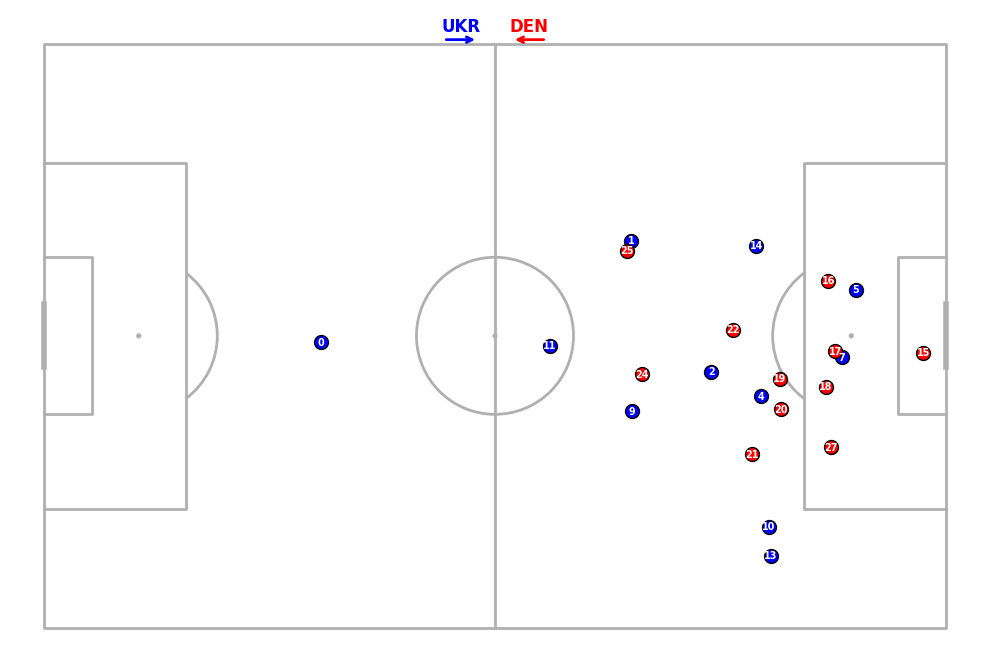

In [9]:
ut.plot_tracking(home=home, away=away, half=1, time=time_passed_in_half, home_color='blue', away_color='red',home_label='UKR',away_label='DEN')

You can also use the dataloader to get the tracking data corresponding to a df of events. For instance, to get all tracking frames for all Danish shots against Ukraine U21:

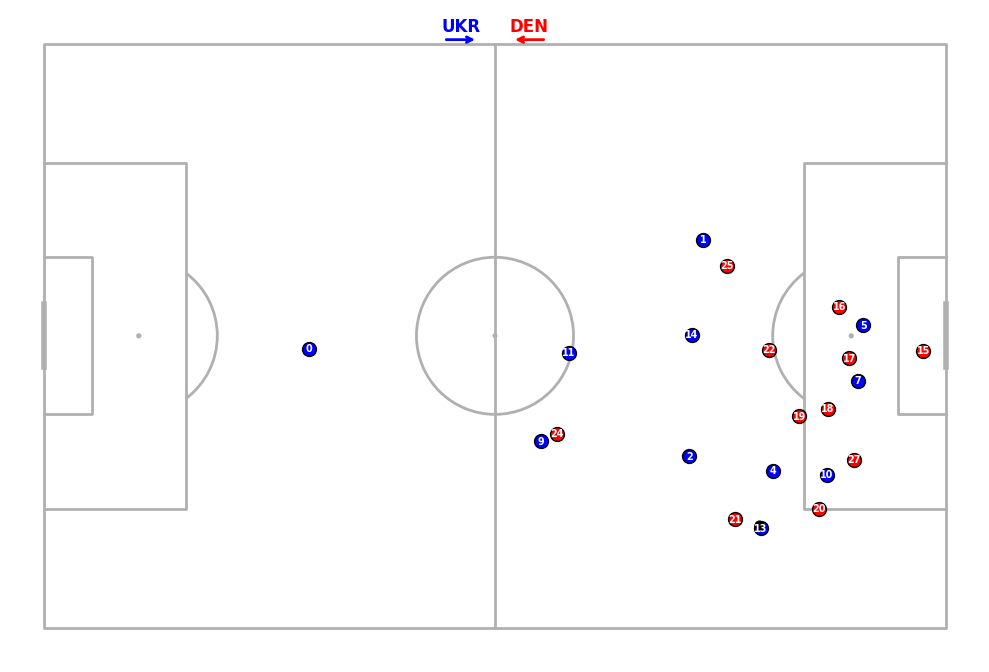

In [10]:
home_da_shots, away_da_shots = data_loader.get_tracking_from_events_data(den_u21_against_ukraine_shots)
# plot the first shot in second half 
ut.plot_tracking(home_da_shots, away_da_shots, half=2, time=0, home_color='blue', away_color='red',home_label='UKR',away_label='DEN')